## IMPORTS

In [ ]:
#@title IMPORTS+ nvidia-smi
from tensorflow.keras import preprocessing
import os
import json
from io import BytesIO
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution,enable_eager_execution
from tensorflow.image import rgb_to_grayscale
#disable_eager_execution()
#tf.compat.v1.experimental.output_all_intermediates(False)
!nvidia-smi
print(tf.__version__)

Thu Apr 21 15:29:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Mount Drive
from google.colab import drive
DRIVE_DIR = '/content/drive/My Drive'
drive.mount('/content/drive')

Mounted at /content/drive


## Load dataset with tagged clothing features

tutaj załaduj dane do "merged_json" wdg wzoru:  


```
[
  {"name":photo_1, "tags":0, 'files':{'nn':{'cache_path':path}}},
  {"name":photo_2, "tags":5, 'files':{'nn':{'cache_path':path}}},
  {"name":photo_3, "tags":2, 'files':{'nn':{'cache_path':path}}},
  ...
]
```


gdzie "path" to ścieżka do danego zdjęcia a "tags" odpowiada liście id kategorii jak podanych w komórce niżej (UWAGA, nie tylko chodzi o kategorię ubioru ale także o jej cechy).   
Dodatkowo zaimplementuj funkcję "load_img" która wczytuje dane zdjęcie do numpy.array.


In [ ]:
#@title Download Data
folder_dir =os.path.join("/","content","drive","My\ Drive","SDD","OUR_DATASET")

if dataset_type=="kbmg":
  datafile_tagged_name = "2022-01-21-tags-tag_new_002.7z"
else:
  datafile_tagged_name = "2022-04-05-colors-colors01.7z"
dataset_tagged_name = datafile_tagged_name[:-3]  
dataset_tagged_dir =os.path.join(folder_dir,datafile_tagged_name)  


## Define categories and example of feature categories

In [ ]:

cats_dict = [
            {'id': 0, 'name': 'dresses',   'nn_output_id': 0, 'feed_cats': [331, 332, 333, 334, 335, 336, 330]},
            {'id': 1, 'name': 'tops',      'nn_output_id': 1, 'feed_cats': [241, 242, 243, 240, 291, 290, 341, 342, 343, 344, 340, 351, 352, 353, 350]},
            {'id': 2, 'name': 'skirts',    'nn_output_id': 2, 'feed_cats': [321, 322, 323, 324, 325, 326, 327, 328, 320]},
            {'id': 3, 'name': 'outerwear', 'nn_output_id': 3, 'feed_cats': [271, 272, 273, 274, 275, 276, 277, 278, 270, 281, 282, 283, 284, 280, 301, 302, 300]},
            {'id': 4, 'name': 'leggings',  'nn_output_id': 4, 'feed_cats': [311, 312, 313, 314, 315, 316, 310]},
    ]

In [ ]:
clothing_cats = ['sukienka','top','spódnica','outwear','spodnie']

In [ ]:
#@title merge tags and display base tags

TAG_BASE_MERGE = {
        'rękaw sukienki': {
            'm/krótszy': ['brak', 'krótki'],
            'm/dłuższy': ['średni 3/4', 'długi']
        },
        'rękaw topu': {
            'm/krótszy': ['brak', 'krótki'],
            'm/dłuższy': ['średni 3/4', 'długi']
        },

        'długość topu': {
            'm/krótsza': ['nad pępek', 'normalna'],
            'm/dłuższa': ['tunika']
        },

        'długość spodni': {
            'm/krótsze': ['krótkie', 'rybaczki'],
            'm/dłuższe': ['bermudy', 'długie']
        },

        'wzór sukienki': {
            'm/paski-krata': ['paski', 'krata']
        },
        'wzór topu': {
            'm/paski-krata': ['paski', 'krata']
        },
        'wzór spódnicy': {
            'm/paski-krata': ['paski', 'krata']
        },
        'wzór outwear': {
            'm/paski-krata': ['paski', 'krata']
        },
        'wzór spodni': {
            'm/paski-krata': ['paski', 'krata']
        },
    }
TAG_MERGE = {k:{vvl:vk for vk,vv in v.items() for vvl in vv}  for k,v in TAG_BASE_MERGE.items()}
print(TAG_MERGE)
for json_idx in range(len(merged_json)):
  for tag_ in merged_json[json_idx]['tags']:
    tag_words = tag_.split(" ")
    if len(tag_words)>2:
      tag_prefix = ' '.join(tag_words[:2])
      tag_affix = ' '.join(tag_words[3:])
      if tag_prefix in TAG_MERGE.keys():
        if tag_affix in TAG_MERGE[tag_prefix]:
          merged_json[json_idx]['tags'].append(tag_prefix+' @ '+TAG_MERGE[tag_prefix][tag_affix])

          

unq_tags=[]
n=0
for photo in merged_json:
  unq_tags.extend(photo['tags'])
  n+=1
unq_tags = np.unique(unq_tags,return_counts=True)
print("Total: ",n)
for i,tag in enumerate(unq_tags[0]):
  print(tag,unq_tags[1][i])


{'rękaw sukienki': {'brak': 'm/krótszy', 'krótki': 'm/krótszy', 'średni 3/4': 'm/dłuższy', 'długi': 'm/dłuższy'}, 'rękaw topu': {'brak': 'm/krótszy', 'krótki': 'm/krótszy', 'średni 3/4': 'm/dłuższy', 'długi': 'm/dłuższy'}, 'długość topu': {'nad pępek': 'm/krótsza', 'normalna': 'm/krótsza', 'tunika': 'm/dłuższa'}, 'długość spodni': {'krótkie': 'm/krótsze', 'rybaczki': 'm/krótsze', 'bermudy': 'm/dłuższe', 'długie': 'm/dłuższe'}, 'wzór sukienki': {'paski': 'm/paski-krata', 'krata': 'm/paski-krata'}, 'wzór topu': {'paski': 'm/paski-krata', 'krata': 'm/paski-krata'}, 'wzór spódnicy': {'paski': 'm/paski-krata', 'krata': 'm/paski-krata'}, 'wzór outwear': {'paski': 'm/paski-krata', 'krata': 'm/paski-krata'}, 'wzór spodni': {'paski': 'm/paski-krata', 'krata': 'm/paski-krata'}}
Total:  16347
buty 687
czapka 34
dekolt sukienki @ brak 33
dekolt sukienki @ duży 28
dekolt sukienki @ golf 7
dekolt sukienki @ mały 64
dekolt sukienki @ średni 66
dekolt topu @ brak 76
dekolt topu @ duży 11
dekolt topu @

## MODEL HYPERPARAMS

In [ ]:
BATCH_SIZE = 194
IMG_SHAPE=(300,300)
INPUT_SHAPE=(300,300,3)
BACKBONE = 'EfficientNetB3'
ARCH_VERSION = 9
LOAD_TO_MEMORY=True
EMBEDDING_ATTENTION_ORDER_NORM = 1
VAE_LOSS_WEIGHT=2e-5
N_ENCODING=256
n_used_cats=5
assert n_used_cats == N_CATEGORIES

In [ ]:
from sklearn.model_selection import train_test_split

TEST_FRAC = 0.15    
X_train, X_test, y_w_train, y_w_test, train_idcs,test_idcs = train_test_split(X,y_w,np.arange(len(X)),test_size=TEST_FRAC, random_state=0)
print("Train samples:", len(X_train),"Test samples:", len(X_test))


## An example of a similarity model with added feature changing output head

In [ ]:
#@title Get model fn
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Reshape, BatchNormalization,\
                                    Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
tf_variable_VAE_loss_weight = tf.Variable(initial_value=VAE_LOSS_WEIGHT,trainable=False)

def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(0.5*sigma) * eps

def get_online_triplet_model(n_used_cats=0,version=0):
    if(BACKBONE=='EfficientNetB1'):
        from tensorflow.keras.applications.efficientnet import EfficientNetB1,preprocess_input
        model_backbone = EfficientNetB1(weights='imagenet',include_top=False, input_shape=(244,244,3))
    elif(BACKBONE=='VGG'):
        from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
        model_backbone = VGG16(weights='imagenet',include_top=False, input_shape=(244,244,3))
    elif(BACKBONE=='EfficientNetB3'):
        from tensorflow.keras.applications.efficientnet import EfficientNetB3,preprocess_input
        model_backbone = EfficientNetB3(weights='imagenet',include_top=False, input_shape=INPUT_SHAPE)
    elif(BACKBONE=='EfficientNetB4'):
        from tensorflow.keras.applications.efficientnet import EfficientNetB4,preprocess_input
        model_backbone = EfficientNetB4(weights='imagenet',include_top=False, input_shape=INPUT_SHAPE)
    elif(BACKBONE=='xception'):
        from tensorflow.keras.applications import Xception
        from tensorflow.keras.applications.xception import preprocess_input
        model_backbone = Xception(weights='imagenet',include_top=False, input_shape=INPUT_SHAPE)
    model_backbone.trainable = False
    x = GlobalAveragePooling2D(name="avg_pool")(model_backbone.outputs[0])
    x = BatchNormalization()(x)    
    x = Flatten()(x)
    x = Dropout(0.3)(x)

    z_vae_encoding = Dense(1536,name="VAE_enc")(x)
    z_mean,z_logvar =tf.split(z_vae_encoding, num_or_size_splits=2, axis=1)            
    x = layers.Lambda(tf.identity, output_shape=(1536//2, ), name='sampled_enc')(z_mean)      
    intermediate_input = Input(1536//2)

    
    inside_encodings=[]
    inside_decoder_encodings=[]
    for i in range(n_used_cats):    
      dense_l = Dense(N_ENCODING)
      x_encoding = dense_l(x)
      x_decoder = dense_l(intermediate_input)
      x_encoding = K.l2_normalize(x_encoding, axis=-1)
      x_decoder = K.l2_normalize(x_decoder, axis=-1)
      inside_encodings.append(x_encoding)
      inside_decoder_encodings.append(x_decoder)
    x_encoding = tf.stack(inside_encodings,axis=1)
    x_decoder = tf.stack(inside_decoder_encodings,axis=1)

    preprocessing_fn = preprocess_input
    inp = Input(INPUT_SHAPE)

    encoder_model = Model(inputs = model_backbone.inputs,outputs=[z_mean,z_logvar], name="Encoder")    
    decoder_model = Model(inputs = intermediate_input,outputs=x_decoder, name="Decoder")    
    one_model = Model(inputs = model_backbone.inputs,outputs=x_encoding, name="EncodingMod")        
    return one_model, encoder_model,decoder_model, preprocessing_fn
    

In [ ]:
triplet_cat_model, encoder, decoder, preprocessing_fn = get_online_triplet_model(n_used_cats=n_used_cats,version=ARCH_VERSION)

43950080/43941136 [==============================] - 1s 0us/step


## Load exisiting model and datasets

In [ ]:
CHECKPOINT_DIR = DRIVE_DIR+"/checkpoints/s2s_v9_EfficientNetB3_300_256_03_KbmgV3D.h5"
triplet_cat_model.load_weights(CHECKPOINT_DIR)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import PIL

if LOAD_TO_MEMORY is True:
  X = np.empty((N_TAGGED_IMAGES+N_UNTAGGED_IMAGES,)+INPUT_SHAPE,dtype='uint8')
  y = np.zeros((N_TAGGED_IMAGES+N_UNTAGGED_IMAGES,N_CATEGORIES),dtype='int')
  if dataset_type=="kbmg":
    for i,photo in enumerate(merged_json):
      y[i] = np.in1d(np.array(clothing_cats),photo['tags'])  
      X[i] = img_to_array(load_img(photo['files']['nn']['cache_path'],color_mode='rgb')) 
  elif dataset_type=="kbmg_both":
    for i,photo in enumerate(merged_json):
      y[i] = np.in1d(np.array(clothing_cats),photo['tags'])  
      y[i,int(photo['nn_cat_id'])] = 1
      X[i] = img_to_array(load_img(photo['files']['nn']['cache_path'],color_mode='rgb')) 
else:
  X = np.empty((N_TAGGED_IMAGES+N_UNTAGGED_IMAGES,),dtype=object)
  y = np.empty((N_TAGGED_IMAGES+N_UNTAGGED_IMAGES,N_CATEGORIES),dtype='int')
  for i,photo in enumerate(merged_json):
    y[i] = np.in1d(np.array(clothing_cats),photo['tags'])  
    X[i] = photo['files']['nn']['cache_path']
  y[len(merged_json):,:] = np.zeros((len(merged_untagged_json),N_CATEGORIES))
  for i,photo in enumerate(merged_untagged_json):
    y[i+N_TAGGED_IMAGES,int(photo['nn_cat_id'])] = 1
    X[i+N_TAGGED_IMAGES] = photo['files']['nn']['cache_path']
w = np.concatenate([TAGGED_WEIGHTS,UNTAGGED_WEIGHTS],axis=0)
y_w = np.concatenate([y,w],axis=1)

## Create calibration file using the gathered data

In [ ]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_fn)
VAE_encs, VAE_stdev = encoder.predict(img_gen.flow(x=X,shuffle=False,batch_size=BATCH_SIZE))

In [ ]:
triplet_encs = triplet_cat_model.predict(img_gen.flow(x=X,shuffle=False,batch_size=BATCH_SIZE))

In [ ]:
triplet_deco_encs = decoder.predict(VAE_encs,batch_size=BATCH_SIZE)

In [ ]:
np.savez(os.path.join(DRIVE_DIR,"SDD","s2s_v9_EfficientNetB3_300_256_03_KbmgV3D"+"_calibration_v3"+".npz"),
         cats = y_w[:,:7],
         tags = np.array([i['tags'] for i in merged_json]),
         triplet_encodings = triplet_encs,
         VAE_encodings = VAE_encs,
         possible_tags = unq_tags[0],
         n_possible_tags = unq_tags[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from sklearn.metrics import pairwise_distances
triplet_dists = [pairwise_distances(triplet_encs[:,i,:], metric='euclidean') for i in range(n_used_cats)]

## Visualize results by changing similarity results from tag1->tag2

In [ ]:
def find_existing_closest_idx(dists,cat,x_idcs,n):
  used_idx = (y_w[:,cat]==1.0)
  assert np.all(np.in1d(x_idcs,used_idx))
  used_dists = dists[cat][x_idcs,:]
  used_dists = used_dists[:,used_idx]
  return np.nonzero(used_idx)[0][np.argsort(used_dists,axis=1)[:,:n]]

def find_closest_idx(cat,x_encs,n):
  dists = pairwise_distances(x_encs, triplet_encs[:,cat,:], metric='euclidean') 
  used_idx = (y_w[:,cat]==1.0)
  dists = dists[:,used_idx]
  return np.nonzero(used_idx)[0][np.argsort(dists,axis=1)[:,:n]]

In [ ]:
tag2 = "wzór topu @ nadruk"
tag1 = "wzór topu @ gładkie"
"""
wzór topu @ centki 8
wzór topu @ grochy 9
wzór topu @ gładkie 860
wzór topu @ krata 26
wzór topu @ kwiaty 78
wzór topu @ nadruk 186
wzór topu @ paski 74
"""
tag1_idx = [i for i in range(len(merged_json)) if tag1 in merged_json[i]['tags']]
tag2_idx = [i for i in range(len(merged_json)) if tag2 in merged_json[i]['tags']]
tag1_VAE_encs = VAE_encs[tag1_idx]
tag2_VAE_encs = VAE_encs[tag2_idx]
tag1_2_tag2_vector = tag2_VAE_encs.mean(axis=0)-tag1_VAE_encs.mean(axis=0)
#tag1_2_tag2_vector = tag1_2_tag2_vector/np.linalg.norm(tag1_2_tag2_vector,ord=1)


def get_closest_idx_from_tag(tag, img_idx, cat, n):
  tag_idcs = np.array([i for i in range(len(merged_json)) if tag in merged_json[i]['tags']])
  triplet_enc = triplet_encs[img_idx]
  dists = pairwise_distances(triplet_enc[cat:cat+1], triplet_encs[tag_idcs,cat,:], metric='euclidean') 
  if n==-1:
    found_idx = tag_idcs
    closest_dists = dists[0,:]
  else:        
    n= min(n,len(tag_idcs))
    found_idx = np.argsort(dists,axis=1)[0,:n]
    closest_dists = dists[0,found_idx]    
    found_idx = tag_idcs[found_idx]  
  return found_idx[found_idx!=img_idx], closest_dists

## An example of similar photos without any tag chagning

In [ ]:
plt.imshow(X[tag1_idx[6]])
plt.axis('off')
plt.show()

plt.figure(figsize=(20,4))
for i in range(len(closest_idx)):
  plt.subplot(1,len(closest_idx),1+i)
  plt.imshow(X[closest_idx[i]])
  plt.axis('off')
plt.show()

## An example how the found similar photos if we add more push towards the tag "top z nadrukiem" -> lower rows have increasing number of "top z nadrukiem"

In [ ]:
tag2 = "wzór topu @ nadruk"
cat = 1
q_idx = tag1_idx[6]
v = VAE_encs[q_idx,:]
closest_idx, closest_dists = get_closest_idx_from_tag(tag2, q_idx,cat=cat, n=2)
print(closest_idx)
transition_vector = VAE_encs[closest_idx].mean(axis=0)-VAE_encs[q_idx]
plt.figure(figsize=(25,25))
for i in range(10):  
  v_i = v + (i/9.0)*transition_vector
  triplet_enc = decoder.predict(v_i[None,...],batch_size=BATCH_SIZE)[:,cat,:]
  found_idx = find_closest_idx(cat,triplet_enc,10)
  for j in range(len(found_idx[0])):
    plt.subplot(10,len(found_idx[0]),10*i + 1+j)
    plt.imshow(X[found_idx[0][j]])
    plt.axis('off')
plt.show()

In [ ]:
cat = 1
idx = tag1_idx[6]
v = VAE_encs[idx:idx+1,:]
plt.figure(figsize=(20,20))
for i in range(10):  
  v_i = v + (i/2.0)*tag1_2_tag2_vector
  triplet_enc = decoder.predict(v_i,batch_size=BATCH_SIZE)[:,cat,:]
  found_idx = find_closest_idx(cat,triplet_enc,10)
  for j in range(len(found_idx[0])):
    plt.subplot(10,len(found_idx[0]),10*i + 1+j)
    plt.imshow(X[found_idx[0][j]])
    plt.axis('off')
plt.show()

## Compare encoding ditributions between two tags

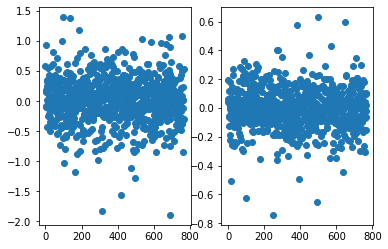

In [ ]:
plt.subplot(121)
plt.scatter(x = np.arange(tag2_VAE_encs.shape[1]),y=tag2_VAE_encs.mean(axis=0))
plt.subplot(122)
plt.scatter(x = np.arange(tag1_VAE_encs.shape[1]),y=tag1_VAE_encs.mean(axis=0)-tag2_VAE_encs.mean(axis=0))
plt.show()

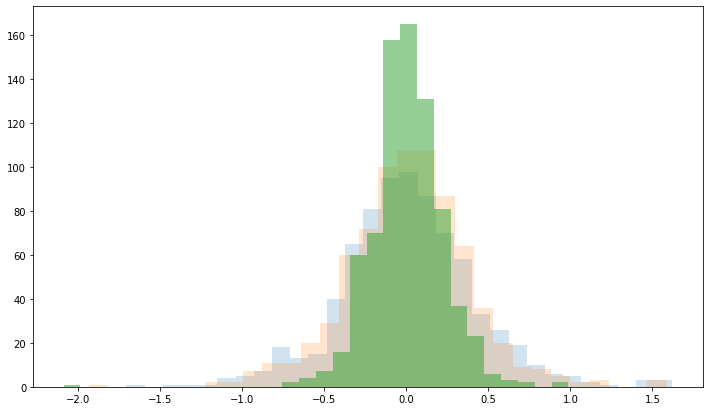

In [ ]:
plt.figure(figsize=(12,7))
plt.hist(tag2_VAE_encs.mean(axis=0),bins=30,alpha=0.2)
plt.hist(tag1_VAE_encs.mean(axis=0),bins=30,alpha=0.2)
plt.hist(tag1_VAE_encs.mean(axis=0)-tag2_VAE_encs.mean(axis=0),bins=30,alpha=0.5)
plt.show()